In [1]:
import pandas as pd
import numpy as np
import random
import string
import scipy.optimize as opt
import seaborn as sns

# Decay functions

In [2]:
def exponential_decay(t, A, lambda_, plateau, noise_std=0):
    """Exponential decay function with added noise."""
    noise = np.random.normal(0, noise_std, len(t))
    return A * np.exp(-lambda_ * t) + plateau + noise

# Sigmoid decay function
def sigmoid_decay(days, start, end, midpoint, steepness, noise_factor=0):
    """
    Generate a sigmoid decay curve that decreases steadily over time.
    """
    days = int(days)  # Ensure `days` is an integer
    t = np.arange(0, days)
    decay = start - ((start - end) / (1 + np.exp(-steepness * (t - midpoint))))
    noise = np.random.normal(0, noise_factor, size=days)
    return np.clip(decay + noise, 0, None)  # Ensure values are non-negative

# Assign decay function
def assign_decay_function(initial_engagement, days=60):
    """
    Assign a decay function (exponential or sigmoid) to a user based on random assignment.
    """
    decay_type = np.random.choice(["sigmoid", "exponential"], p=[0.9, 0.1])  # 90% sigmoid, 10% exponential
    t = np.arange(0, days)  # Define the time array for exponential decay

    if decay_type == "exponential":
        decay_rate = np.random.uniform(0.01, 0.05)  # Random exponential decay rate
        plateau = np.random.uniform(50, 80)  # Random plateau level
        noise_std = np.random.uniform(1, 3)  # Noise level
        decay_values = exponential_decay(t, initial_engagement, decay_rate, plateau, noise_std)

    else:  # Sigmoid decay
        L = initial_engagement  # Starting value
        plateau = np.random.uniform(50, 80)  # Random plateau level
        k = np.random.uniform(0.01, 0.1)  # Steepness of the curve
        t0 = np.random.uniform(20, 40)  # Midpoint of the sigmoid curve
        noise_std = np.random.uniform(1, 3)  # Noise level
        decay_values = sigmoid_decay(days, L, plateau, t0, k, noise_std)

    return decay_values

# Log Normal Functions

In [3]:


def calculate_lognormal_params(mode, std, size=1000, noise_std=0.0):
    """
    Automatically calculate log-normal parameters (mu, sigma) based on mode and real-space standard deviation.
    Generate the log-normal distribution with added noise.
    
    Parameters:
        mode (float): Desired mode of the log-normal distribution.
        std (float): Desired standard deviation of the real-space distribution.
        size (int): Number of samples to generate (default: 1000).
        noise_std (float): Gaussian noise standard deviation to add to the data (default: 0.0).
    
    Returns:
        np.ndarray: Generated log-normal distribution.
    """
    def equations(log_params):
        sigma_squared, mu = log_params
        real_mean = np.exp(mu + sigma_squared / 2)
        real_variance = (np.exp(sigma_squared) - 1) * np.exp(2 * mu + sigma_squared)
        real_std = np.sqrt(real_variance)
        return [
            np.log(mode) - (mu - sigma_squared / 2),  # Constraint for mode
            std - real_std                           # Constraint for std
        ]

    # Initial guesses for sigma^2 and mu
    initial_guess = [0.5, np.log(mode)]
    sigma_squared, mu = opt.root(equations, initial_guess).x

    # Generate the log-normal distribution
    sigma = np.sqrt(sigma_squared)
    data = np.random.lognormal(mean=mu, sigma=sigma, size=size)

    # Add optional Gaussian noise
    if noise_std > 0:
        data += np.random.normal(0, noise_std, size=size)
        data = np.clip(data, 0, None)

    return data, mu, sigma

# # Example Usage
# data, mu, sigma = calculate_lognormal_params(mode=20, std=5, size=10000)
# print(f"Calculated mu: {mu}, sigma: {sigma}")

# # Plot the results
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 5))
# plt.hist(data, bins=100, edgecolor='black', alpha=0.7)
# plt.title("Log-Normal Distribution with Calculated Parameters")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# User Class

In [4]:
import pandas as pd
import numpy as np
import random
import string



# Function to generate a random User ID
def generate_user_id():
    letters = ''.join(random.choices(string.ascii_uppercase, k=4))
    numbers = ''.join(random.choices(string.digits, k=4))
    return letters + numbers

class User:
    def __init__(self, user_id, group, days=180):
        self.user_id = user_id  # Unique User ID
        self.group = group  # User Group (Baseline, Drifters, Power Users)
        self.days = days  # Number of days for data generation

        # Initialize group-specific distributions
        self.ctr_group, self.ctr_x, self.ctr_y = self._init_ctr()
        self.drop_off_group, self.drop_x, self.drop_y = self._init_drop_off()
        self.engage_params = self._init_engagement()
        self.likes_group, self.likes_range, self.likes_params = self._init_likes()
        self.shares_group, self.shares_params = self._init_shares()
        self.comments_group, self.comments_params = self._init_comments()

        # Generate the user's data
        self.data = self.generate_metrics()

    def _init_ctr(self):
        ctr_group = np.random.choice(["Standard Users", "Curiosities"], p=[0.95, 0.05])
        if ctr_group == "Standard Users":
            ctr_x = np.random.uniform(0.01, 0.03) + np.random.normal(0, 0.005)
            ctr_y = np.random.uniform(0.03, 0.05) + np.random.normal(0, 0.005)
        else:  # Curiosities
            ctr_x = np.random.uniform(0.05, 0.1) + np.random.normal(0, 0.005)
            ctr_y = np.random.uniform(0.1, 0.2) + np.random.normal(0, 0.005)
        return ctr_group, ctr_x, ctr_y

    def _init_drop_off(self):
        drop_off_group = self.group
        if drop_off_group == "Baseline":
            drop_x = np.random.uniform(0.01, 0.05) + np.random.normal(0, 0.005)
            drop_y = np.random.uniform(0.05, 0.1) + np.random.normal(0, 0.005)
        elif drop_off_group == "Drifters":
            drop_x = np.random.uniform(0.05, 0.15) + np.random.normal(0, 0.005)
            drop_y = np.random.uniform(0.01, 0.05) + np.random.normal(0, 0.005)
        else:  # Power Users
            drop_x = 0.01
            drop_y = 0.05
        return drop_off_group, drop_x, drop_y

    def _init_engagement(self):
        """Initialize Engagement distributions based on the user group."""
        if self.group == "Power Users":
            engage_params = {
                "unif_x": np.random.uniform(90, 120),
                "unif_y": np.random.uniform(130, 180),
                "mean": None,
                "sigma": None,
                "noise": np.random.uniform(0, 1)
            }
        elif self.group == "Drifters":
            engage_params = {
                "unif_x": None,
                "unif_y": None,
                "mean": np.random.uniform(50, 150),
                "sigma": np.random.uniform(20, 70),
                "noise": np.random.uniform(0, 1)
            }
        else:  # Baseline
            engage_params = {
                "mode": np.random.uniform(30, 65),  # Desired mode for log-normal
                "std": np.random.uniform(5, 10),  # Desired standard deviation for log-normal
                "noise": np.random.uniform(1, 5)  # Additional noise
            }
        return engage_params

    def _init_likes(self):
        likes_group = np.random.choice(["Baseline", "Power Users", "Drifters"], p=[0.75, 0.05, 0.2])
        if likes_group == "Baseline":
            likes_range = (0.02, 0.05)
            likes_params = {"noise": (-0.02, 0.02)}
        elif likes_group == "Power Users":
            likes_x = np.random.uniform(0.06, 0.1) + np.random.normal(0, 0.005)
            likes_y = np.random.uniform(0.11, 0.35) + np.random.normal(0, 0.005)
            likes_range = (likes_x, likes_y)
            likes_params = None
        else:  # Drifters with cyclical pattern
            likes_mean = np.random.uniform(0.05, 0.15) + np.random.normal(0, 0.005)
            likes_std = np.random.uniform(0.02, 0.05) + np.random.normal(0, 0.005)
            period = np.random.uniform(15, 45)
            likes_range = (likes_mean, likes_std)
            likes_params = {"period": period}
        return likes_group, likes_range, likes_params

    def _init_shares(self):
        shares_group = np.random.choice(["Baseline", "Power Users", "Drifters"], p=[0.75, 0.05, 0.2])
        if shares_group == "Baseline":
            shares_params = {
                "mean": np.random.uniform(-5, -4),
                "sigma": np.random.uniform(0.3, 0.5),
            }
        elif shares_group == "Power Users":
            shares_params = {"range": (0.05, 0.1)}
        else:  # Drifters
            shares_mean = np.random.uniform(0.02, 0.05) + np.random.normal(0, 0.005)
            shares_std = np.random.uniform(0.01, 0.02) + np.random.normal(0, 0.005)
            period = np.random.uniform(15, 45)
            shares_params = {"mean": shares_mean, "std": shares_std, "period": period}
        return shares_group, shares_params

    def _init_comments(self):
        comments_group = np.random.choice(["Baseline", "Power Users"], p=[0.95, 0.05])
        if comments_group == "Baseline":
            comments_params = {"mean": -4.5, "sigma": 0.3}
        else:  # Power Users
            comments_params = {"range": (0.02, 0.05)}
        return comments_group, comments_params

    def _generate_likes(self):
        if self.likes_group == "Baseline":
            likes_data = (
                np.random.uniform(*self.likes_range, size=self.days)
                + np.random.uniform(*self.likes_params["noise"], size=self.days)
            )
        elif self.likes_group == "Power Users":
            likes_data = np.random.uniform(*self.likes_range, size=self.days)
        else:  # Drifters with cyclical pattern
            likes_mean, likes_std = self.likes_range
            period = self.likes_params["period"]
            likes_data = np.random.normal(likes_mean, likes_std, size=self.days)
            likes_data += 0.05 * np.sin(np.linspace(0, 2 * np.pi, self.days) / period)
            likes_data = np.clip(likes_data, 0, 1)
        return likes_data

    def _generate_shares(self):
        if self.shares_group == "Baseline":
            shares_data = np.random.lognormal(
                mean=self.shares_params["mean"], sigma=self.shares_params["sigma"], size=self.days
            )
        elif self.shares_group == "Power Users":
            shares_data = np.random.uniform(*self.shares_params["range"], size=self.days)
        else:  # Drifters with volatility
            shares_mean = self.shares_params["mean"]
            shares_std = self.shares_params["std"]
            period = self.shares_params["period"]
            shares_data = np.random.normal(shares_mean, shares_std, size=self.days)
            shares_data += 0.01 * np.sin(np.linspace(0, 2 * np.pi, self.days) / period)
            shares_data = np.clip(shares_data, 0, 1)
        return shares_data

    def _generate_comments(self):
        if self.comments_group == "Baseline":
            comments_data = np.random.lognormal(
                mean=self.comments_params["mean"], sigma=self.comments_params["sigma"], size=self.days
            )
            comments_data = np.clip(comments_data, 0, 0.2)
        else:  # Power Users
            comments_data = np.random.uniform(*self.comments_params["range"], size=self.days)
        return comments_data

    def generate_metrics(self):
        """Generate daily metrics for the user."""
        dates = pd.date_range(start="2024-01-01", periods=self.days)

        # CTR
        ctr_data = np.random.uniform(self.ctr_x, self.ctr_y, size=self.days)

        # Drop-Off Rate
        if self.drop_off_group == "Baseline":
            drop_off_data = np.random.uniform(self.drop_x, self.drop_y, size=self.days)
        elif self.drop_off_group == "Drifters":
            drop_off_data = np.clip(
                np.random.normal(self.drop_x, self.drop_y, size=self.days), 0, 1
            )
        else:  # Power Users
            drop_off_data = np.random.uniform(self.drop_x, self.drop_y, size=self.days)

        # Engagement Time
        if self.group == "Baseline":
            # Use calculate_lognormal_params for Baseline group
            mode = self.engage_params["mode"]
            std = self.engage_params["std"]
            noise_std = self.engage_params["noise"]
            engagement_data, _, _ = calculate_lognormal_params(
                mode=mode, std=std, size=self.days, noise_std = noise_std
            )
            # Add noise
            engagement_data += self.engage_params["noise"] * np.random.normal(0, 1, size=self.days)
            # Clip data between 0 and 200
            engagement_data = np.clip(engagement_data, 0, 200)
        elif self.group == "Power Users":
            # Uniform engagement for Power Users
            engagement_data = np.random.uniform(
                self.engage_params["unif_x"], self.engage_params["unif_y"], size=self.days
            )
        else:  # Drifters
            # Normal distribution with clipping for Drifters
            engagement_data = np.clip(
                np.random.normal(self.engage_params["mean"], self.engage_params["sigma"], size=self.days), 
                30, 200
            )

        # Add cyclical pattern
        period = np.random.uniform(15, 45)
        engagement_data += 10 * np.sin(np.linspace(0, 2 * np.pi, self.days) / period)

        # Likes, Shares, Comments
        likes_data = self._generate_likes()
        shares_data = self._generate_shares()
        comments_data = self._generate_comments()

        # Create dataframe
        return pd.DataFrame({
            "Date": dates,
            "CTR": ctr_data,
            "CTR Group": self.ctr_group,
            "Drop-Off Rate": drop_off_data,
            "Drop-Off Group": self.drop_off_group,
            "Engagement Time (minutes)": engagement_data,
            "Likes Given": likes_data,
            "Likes Group": self.likes_group,
            "Shares": shares_data,
            "Shares Group": self.shares_group,
            "Comments Written": comments_data,
            "Comments Group": self.comments_group
        })


# Generate multiple users and Time A
def generate_users(n_users, days=180):
    users = []
    for _ in range(n_users):
        user_id = generate_user_id()
        group = np.random.choice(["Baseline", "Drifters", "Power Users"], p=[0.63, 0.21, 0.16])
        users.append(User(user_id, group, days))
    return users

def generate_time_a(n_users, days=180, seed_a=None):
    if seed_a is not None:
        random.seed(seed_a)
        np.random.seed(seed_a)

    users = []
    for _ in range(n_users):
        user_id = generate_user_id()
        group = np.random.choice(["Baseline", "Drifters", "Power Users"], p=[0.63, 0.21, 0.16])
        users.append(User(user_id, group, days))
    return pd.concat([user.data.assign(UserID=user.user_id, Group=user.group) for user in users])

time_a_df = generate_time_a(100, days=180, seed_a=105)


C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning: invalid value encountered in sqrt
  real_std = np.sqrt(real_variance)
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning: invalid value encountered in sqrt
  real_std = np.sqrt(real_variance)
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning: invalid value encountered in sqrt
  real_std = np.sqrt(real_variance)
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning: invalid value encountered in sqrt
  real_std = np.sqrt(real_variance)
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning: invalid value encountered in sqrt
  real_std = np.sqrt(real_variance)
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning: invalid value encountered in sqrt
  real_std = np.sqrt(real_variance)
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\1019031654.py:19: RuntimeWarning:

In [5]:
# Apply decay with noise function (standalone, not nested)
def apply_decay_with_noise(initial_engagement, rng, decay_days=60, total_days=180):
    """
    Apply decay with noise to a user's engagement time.

    Args:
    - initial_engagement: Initial engagement time (e.g., minutes).
    - rng: Random state for reproducibility.
    - decay_days: Number of days for decay simulation.
    - total_days: Total number of days in Time B.

    Returns:
    - Combined decay and plateau values as a numpy array.
    """
    # Decay for the first `decay_days`
    decay_values = assign_decay_function(
        initial_engagement=initial_engagement,
        rng=rng,
        days=decay_days
    )

    # Plateau value after decay
    plateau_value = decay_values[-1]

    # Add noise to the plateau
    plateau_noise = rng.normal(loc=0, scale=1, size=total_days - decay_days)
    plateau_values = np.full(total_days - decay_days, plateau_value) + plateau_noise

    # Clip plateau values to ensure they're realistic
    plateau_values = np.clip(plateau_values, 0, 200)  # Ensure values stay within 0 to 200 minutes

    # Combine decay values and plateau values
    return np.concatenate([decay_values, plateau_values])


def generate_time_b_with_decay(time_a_df, decay_days=60, total_days=180, seed=None):
    """
    Generate Time B by applying decay functions for the first `decay_days` 
    and stabilizing engagement time after decay with added noise.

    Args:
    - time_a_df: DataFrame of Time A.
    - decay_days: Number of days for decay simulation.
    - total_days: Total number of days for Time B (default: 180).
    - seed: Seed for reproducibility.

    Returns:
    - time_b_df: DataFrame of Time B.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize Time B DataFrame
    time_b_data = []

    # Group Time A data by UserID
    grouped_time_a = time_a_df.groupby("UserID")
    
    for user_id, user_data in grouped_time_a:
        # Set user-specific seed for reproducibility
        user_seed = None if seed is None else hash(user_id) % (2**32)
        rng = np.random.default_rng(user_seed)

        # Extract Time A distribution properties for this user
        initial_engagement = user_data["Engagement Time (minutes)"].iloc[0]
        ctr_range = (user_data["CTR"].min(), user_data["CTR"].max())
        drop_off_range = (user_data["Drop-Off Rate"].min(), user_data["Drop-Off Rate"].max())
        
        # Apply decay function to engagement time using rng
        decay_values = assign_decay_function(initial_engagement, rng=rng, days=decay_days)

        # Plateau values after decay
        plateau_value = decay_values[-1]
        plateau_noise = rng.normal(loc=0, scale=1, size=total_days - decay_days)
        plateau_values = np.full(total_days - decay_days, plateau_value) + plateau_noise
        plateau_values = np.clip(plateau_values, 0, 200)

        # Combine decay and plateau values
        engagement_time_b = np.concatenate([decay_values, plateau_values])

        # Generate new CTR and Drop-Off values for Time B
        ctr_data_b = rng.uniform(*ctr_range, total_days)
        drop_off_data_b = rng.uniform(*drop_off_range, total_days)

        # Add Time B data for this user
        user_time_b = pd.DataFrame({
            "Date": pd.date_range(start="2024-07-01", periods=total_days),
            "UserID": user_id,
            "CTR": ctr_data_b,
            "Drop-Off Rate": drop_off_data_b,
            "Engagement Time (minutes)": engagement_time_b,
            "Likes Given": user_data["Likes Given"].mean(),  # Example; add new logic as needed
            "Shares": user_data["Shares"].mean(),           # Example; add new logic as needed
            "Comments Written": user_data["Comments Written"].mean()  # Example; add new logic as needed
        })
        time_b_data.append(user_time_b)

    # Combine all user data into a single DataFrame
    time_b_df = pd.concat(time_b_data, ignore_index=True)
    return time_b_df


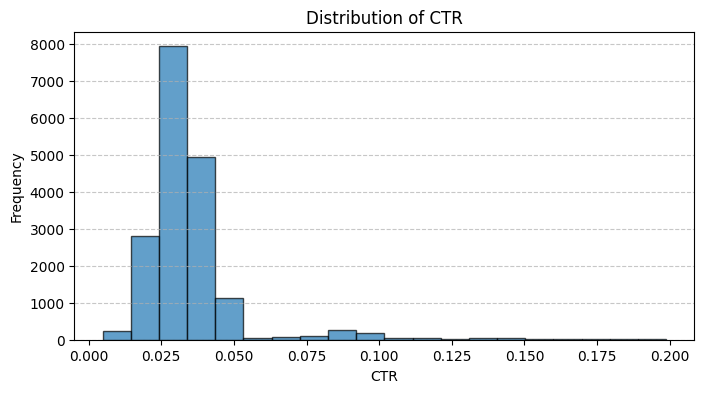

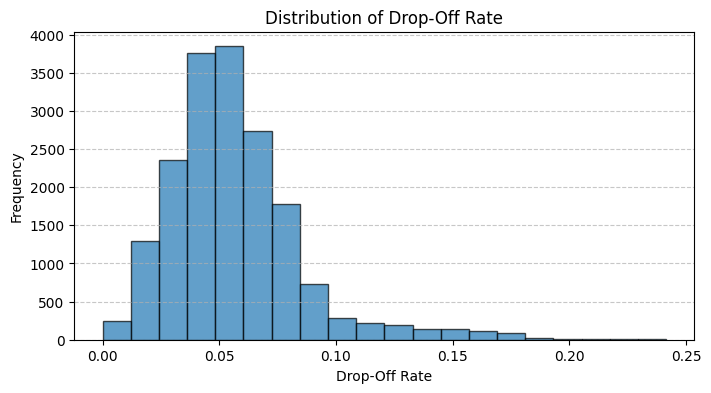

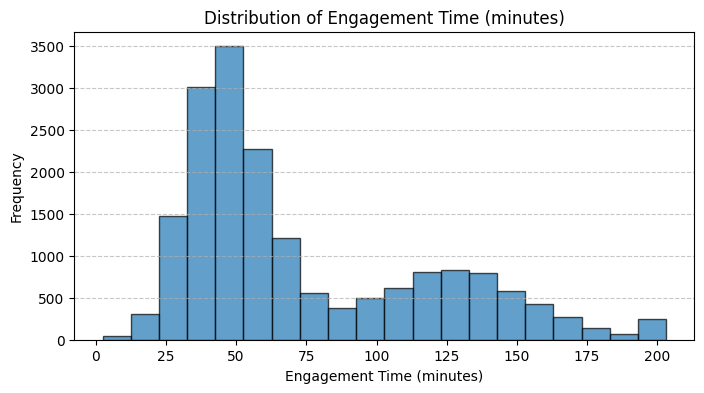

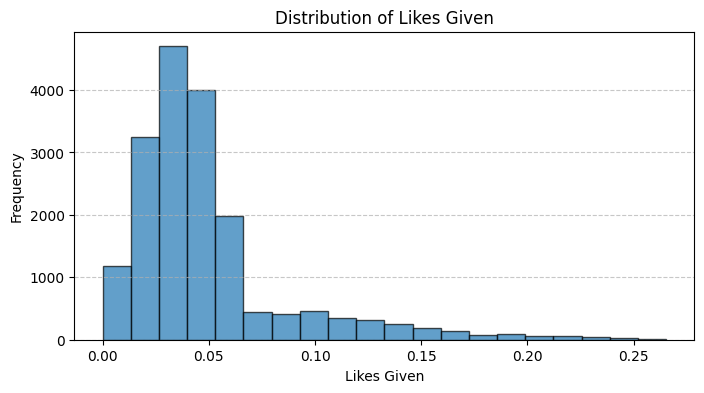

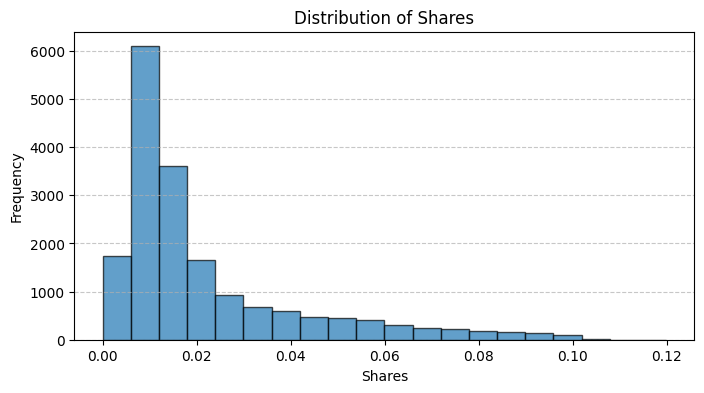

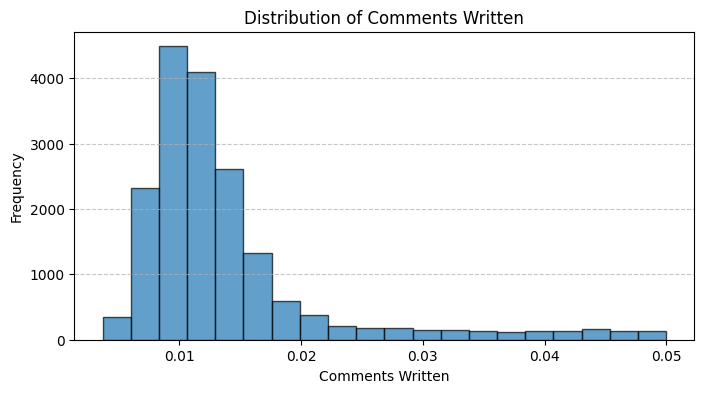

In [6]:
import matplotlib.pyplot as plt
columns_to_check = [
    "CTR", 
    "Drop-Off Rate", 
    "Engagement Time (minutes)", 
    "Likes Given", 
    "Shares", 
    "Comments Written"
]

for column in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.hist(time_a_df[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [7]:
def generate_time_b_with_plateau(time_a_df, decay_days=60, total_days=180, seed_b=None):
    """
    Generate Time B data by applying decay functions only to high-engagement users 
    (>100 avg minutes in Time A) while maintaining consistency for other metrics.

    Args:
    - time_a_df: DataFrame of Time A data.
    - decay_days: Number of days for decay simulation.
    - total_days: Total number of days for Time B (default: 180).
    - seed_b: Seed value for reproducibility in Time B generation.

    Returns:
    - time_b_df: DataFrame of Time B.
    """
    if seed_b is not None:
        random.seed(seed_b)
        np.random.seed(seed_b)

    # Identify high-engagement users
    high_engagement_users = time_a_df.groupby("UserID")["Engagement Time (minutes)"].mean()
    high_engagement_users = high_engagement_users[high_engagement_users > 100].index

    # Initialize storage for Time B data
    time_b_data = []

    # Iterate through each user
    for user_id, user_data in time_a_df.groupby("UserID"):
        user_data = user_data.iloc[:total_days].copy()

        if user_id in high_engagement_users:
            # Apply decay to engagement time
            initial_engagement = user_data.iloc[0]["Engagement Time (minutes)"]
            decay_values = assign_decay_function(initial_engagement, days=decay_days)

            # Plateau logic after decay
            plateau_value = decay_values[-1]
            plateau_noise = np.random.normal(0, 1, total_days - decay_days)
            plateau_values = np.full(total_days - decay_days, plateau_value) + plateau_noise
            plateau_values = np.clip(plateau_values, 0, 200)

            # Combine decay and plateau
            engagement_time_b = np.concatenate([decay_values, plateau_values])
            user_data["Engagement Time (minutes)"] = engagement_time_b
        else:
            # For low-engagement users, retain the same engagement time as Time A
            user_data["Engagement Time (minutes)"] = user_data["Engagement Time (minutes)"].values[:total_days]

        # Retain other metrics from Time A
        user_data["CTR"] = user_data["CTR"].values[:total_days]
        user_data["Drop-Off Rate"] = user_data["Drop-Off Rate"].values[:total_days]
        user_data["Likes Given"] = user_data["Likes Given"].values[:total_days]
        user_data["Shares"] = user_data["Shares"].values[:total_days]
        user_data["Comments Written"] = user_data["Comments Written"].values[:total_days]

        # Append user's Time B data
        time_b_data.append(user_data)

    # Concatenate all user data into a single DataFrame
    time_b_df = pd.concat(time_b_data, ignore_index=True)

    return time_b_df


C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\776492700.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(time_a_df["Engagement Time (minutes)"],
C:\Users\Danny\AppData\Local\Temp\ipykernel_3844\776492700.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(time_b_df["Engagement Time (minutes)"],


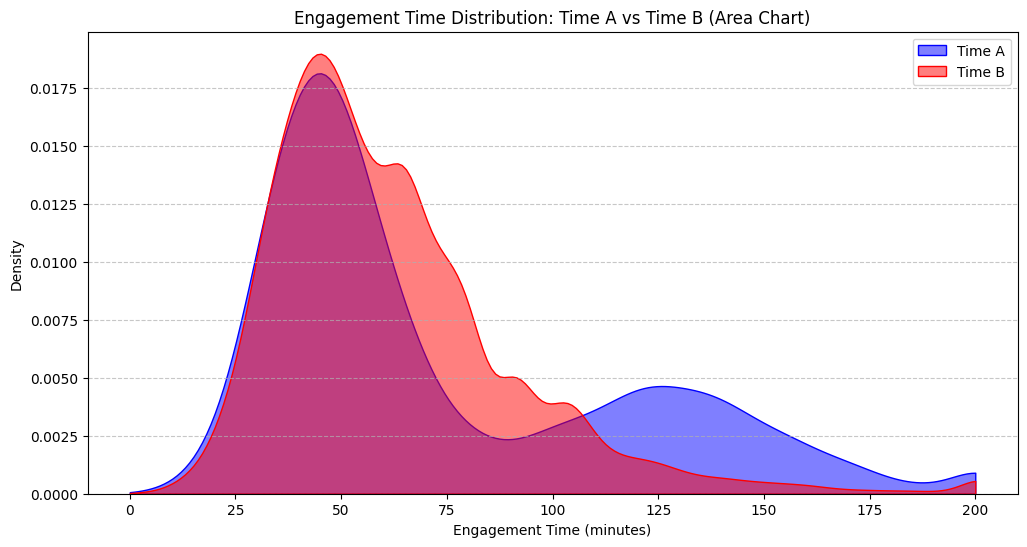

In [8]:


# Generate Time B
time_b_df = generate_time_b_with_plateau(time_a_df, decay_days=60, total_days=180, seed_b = 1001)

# Standalone area chart for Time A vs Time B
def plot_time_a_vs_time_b_area(time_a_df, time_b_df):
    """
    Create a standalone area chart comparing Time A and Time B engagement time distributions.
    
    Args:
    - time_a_df: DataFrame for Time A.
    - time_b_df: DataFrame for Time B.
    """
    plt.figure(figsize=(12, 6))

    # Time A Area Plot
    sns.kdeplot(time_a_df["Engagement Time (minutes)"], 
                shade=True, alpha=0.5, label="Time A", color="blue", clip=(0, 200))

    # Time B Area Plot
    sns.kdeplot(time_b_df["Engagement Time (minutes)"], 
                shade=True, alpha=0.5, label="Time B", color="red", clip=(0, 200))

    # Chart details
    plt.title("Engagement Time Distribution: Time A vs Time B (Area Chart)")
    plt.xlabel("Engagement Time (minutes)")
    plt.ylabel("Density")
    plt.legend(loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function to plot
plot_time_a_vs_time_b_area(time_a_df, time_b_df)


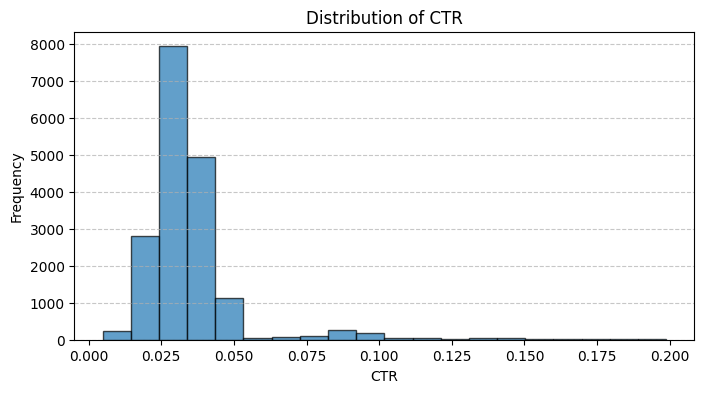

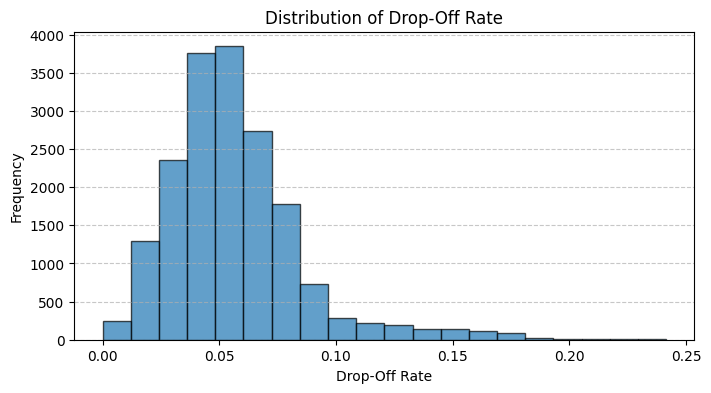

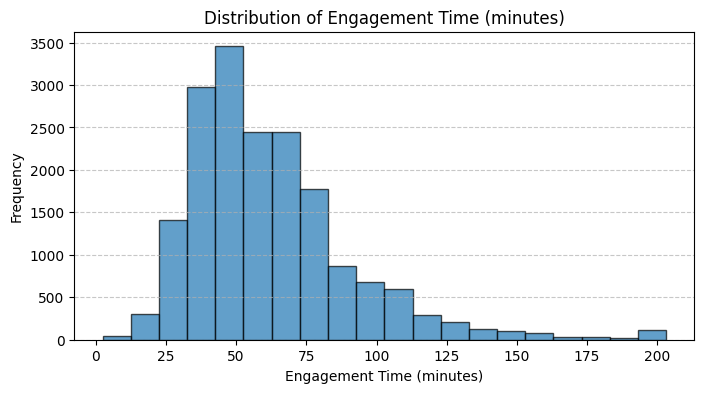

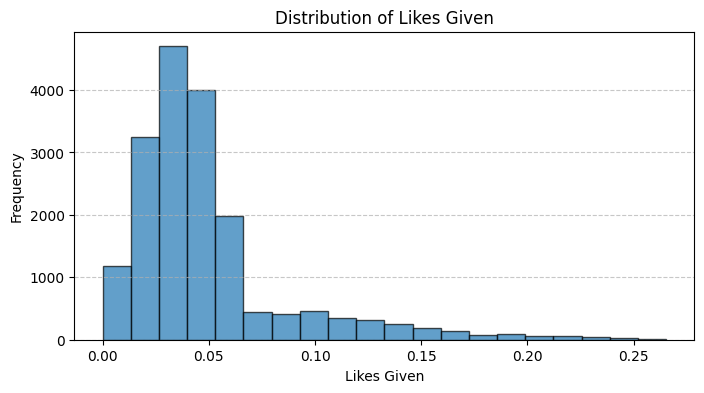

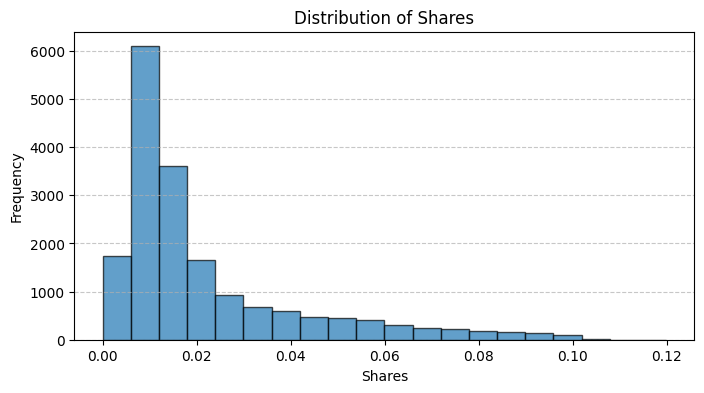

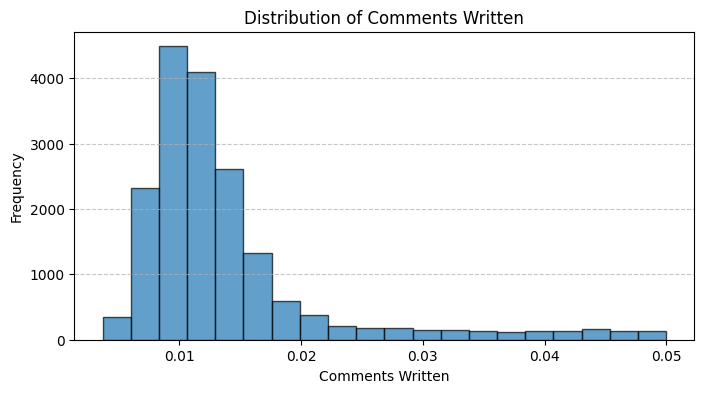

In [9]:
import matplotlib.pyplot as plt
columns_to_check = [
    "CTR", 
    "Drop-Off Rate", 
    "Engagement Time (minutes)", 
    "Likes Given", 
    "Shares", 
    "Comments Written"
]

for column in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.hist(time_b_df[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [10]:
time_b_df.head().to_clipboard()

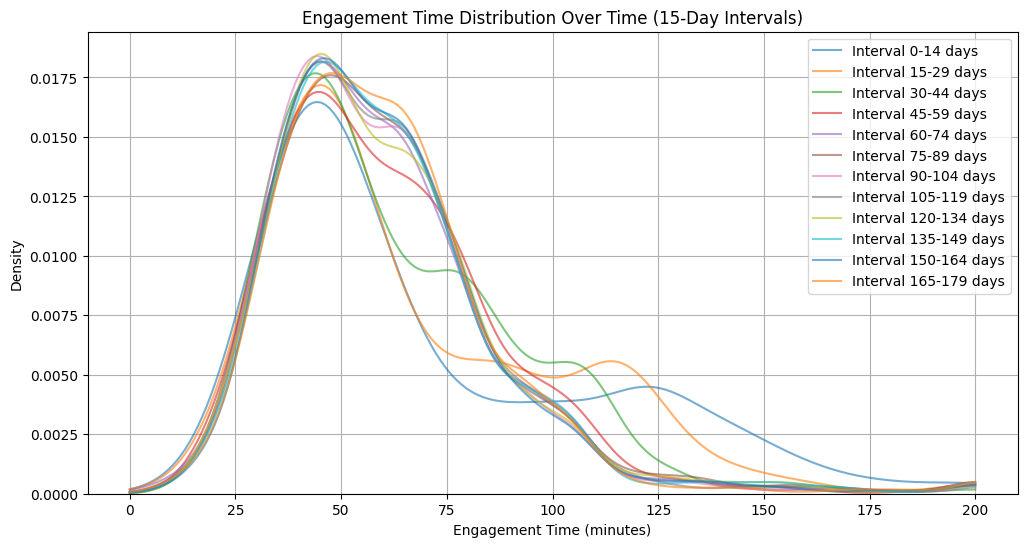

In [11]:
# Adjusted snapshots of the distribution every 15 days
def plot_snapshot_distributions_15_day(time_b_df):
    # Extract data for every 15-day interval
    time_b_df["15-Day Interval"] = (time_b_df.index // 15) % 12  # Group data by 15-day intervals
    unique_intervals = sorted(time_b_df["15-Day Interval"].unique())
    
    plt.figure(figsize=(12, 6))
    for interval in unique_intervals:
        interval_data = time_b_df[time_b_df["15-Day Interval"] == interval]
        sns.kdeplot(interval_data["Engagement Time (minutes)"], 
                    label=f"Interval {interval*15}-{(interval+1)*15-1} days",
                    clip=(0, 200), 
                    alpha=0.6)
    plt.legend()
    plt.title("Engagement Time Distribution Over Time (15-Day Intervals)")
    plt.xlabel("Engagement Time (minutes)")
    plt.ylabel("Density")
    plt.grid()
    plt.show()

# Adjusted animation for 15-day intervals
def animate_distributions_15_day(time_b_df):
    fig, ax = plt.subplots(figsize=(10, 5))

    time_b_df["Day"] = time_b_df.index % 180  # Create a Day column for animation
    max_day = time_b_df["Day"].max()

    def update(day):
        ax.clear()
        data_day = time_b_df[time_b_df["Day"] == day]
        ax.hist(data_day["Engagement Time (minutes)"], bins=50, alpha=0.7, color="blue")
        ax.set_title(f"Engagement Time Distribution on Day {day}")
        ax.set_xlabel("Engagement Time (minutes)")
        ax.set_ylabel("Frequency")
        ax.set_xlim(0, 200)
        ax.set_ylim(0, 100)  # Adjust based on expected range
        ax.grid()

    ani = FuncAnimation(fig, update, frames=range(0, max_day + 1, 15), repeat=False)
    plt.show()

# Example usage for 15-day interval visualizations
plot_snapshot_distributions_15_day(time_b_df)  # Snapshot of distributions every 15 days
#animate_distributions_15_day(time_b_df)  # Animated 15-day interval visualization



# Export 

In [12]:
time_b_df.to_csv(r'c:\Users\danie\OneDrive\Desktop\Simulation\Drift Detection\CSV\time_b_df.csv')
time_a_df.to_csv(r'c:\Users\danie\OneDrive\Desktop\Simulation\Drift Detection\CSV\time_a_df.csv')

OSError: Cannot save file into a non-existent directory: 'c:\Users\danie\OneDrive\Desktop\Simulation\Drift Detection\CSV'

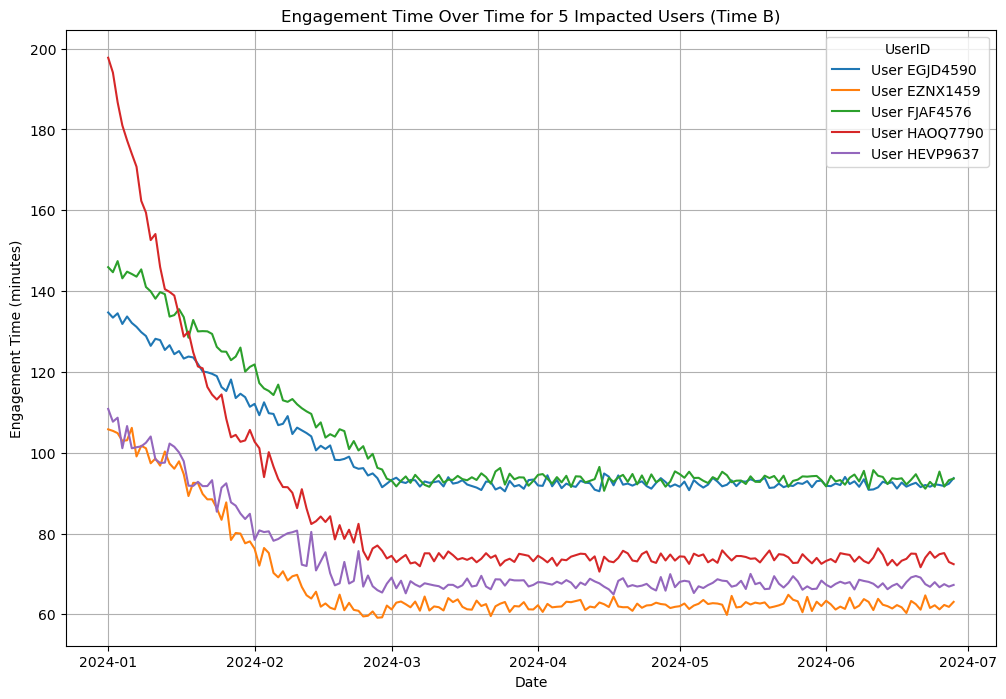

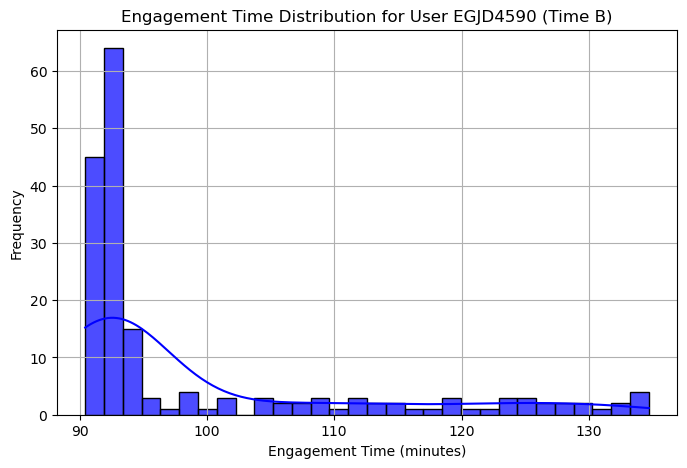

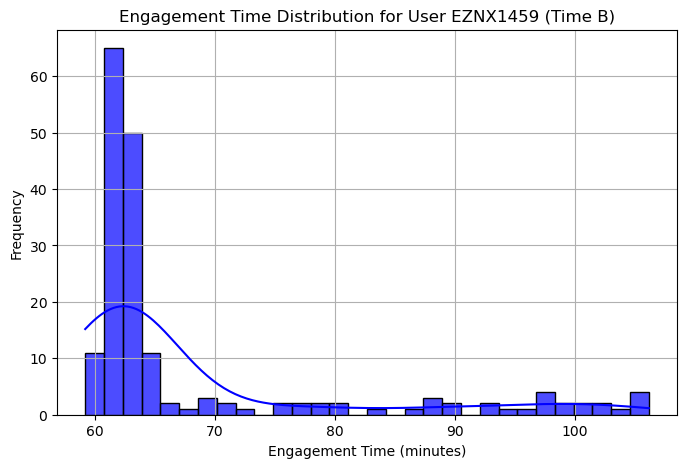

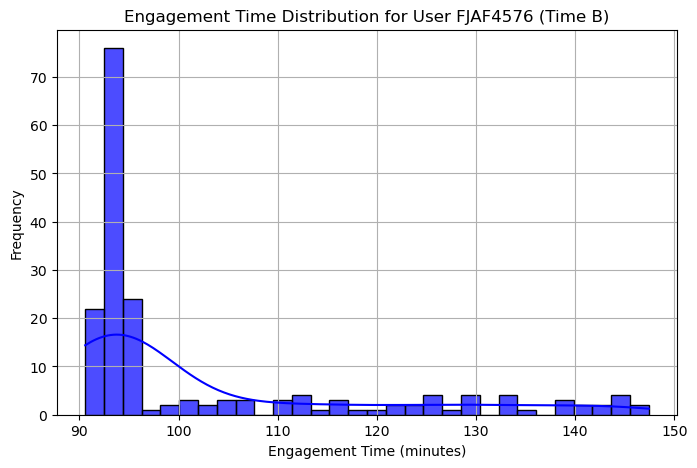

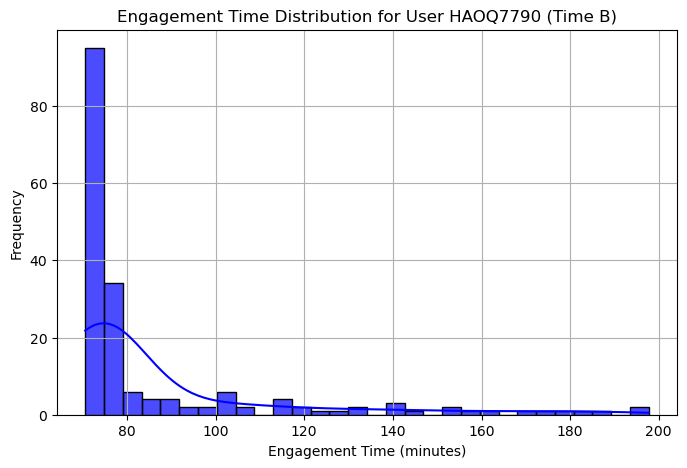

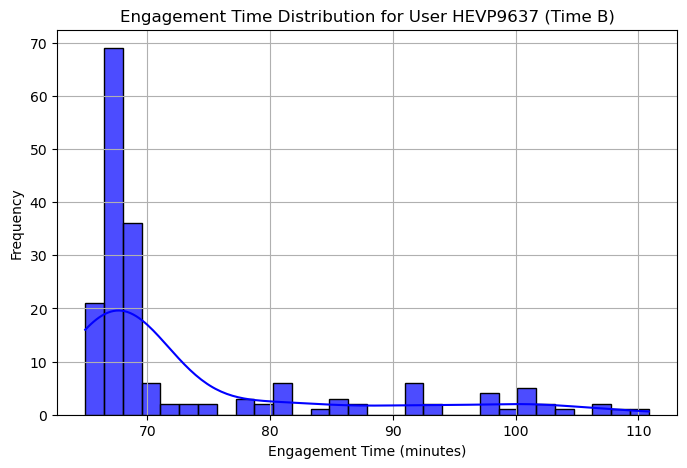

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter impacted users
high_engagement_users = time_a_df.groupby("UserID")["Engagement Time (minutes)"].mean()
impacted_users = high_engagement_users[high_engagement_users > 100].index

# Sample 5 impacted users
sample_users = impacted_users[:5]  # Adjust this if you want random sampling
sample_data = time_b_df[time_b_df["UserID"].isin(sample_users)]

# Plot engagement time for each user
plt.figure(figsize=(12, 8))
for user_id in sample_users:
    user_data = sample_data[sample_data["UserID"] == user_id]
    plt.plot(user_data["Date"], user_data["Engagement Time (minutes)"], label=f"User {user_id}")

# Chart details
plt.title("Engagement Time Over Time for 5 Impacted Users (Time B)")
plt.xlabel("Date")
plt.ylabel("Engagement Time (minutes)")
plt.legend(title="UserID")
plt.grid()
plt.show()

# Histograms for each user
for user_id in sample_users:
    plt.figure(figsize=(8, 5))
    user_data = sample_data[sample_data["UserID"] == user_id]
    sns.histplot(user_data["Engagement Time (minutes)"], bins=30, kde=True, color="blue", alpha=0.7)
    plt.title(f"Engagement Time Distribution for User {user_id} (Time B)")
    plt.xlabel("Engagement Time (minutes)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
